In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2024-04-08 11:48:42--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-04-08 11:48:42 (16.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = (320, 320)

In [4]:
# Walk through each directory
dataset = "../input/fire-dataset/fire_dataset"
walk_through_dir(dataset)

There are 2 directories and 0 images in '../input/fire-dataset/fire_dataset'.
There are 0 directories and 244 images in '../input/fire-dataset/fire_dataset/non_fire_images'.
There are 0 directories and 755 images in '../input/fire-dataset/fire_dataset/fire_images'.


In [5]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [6]:
len(list(image_dir.glob(r'**/*.png')))

999

In [7]:
image_df

,Filepath,Label
0,../input/fire-dataset/fire_dataset/non_fire_im...,non_fire_images
1,../input/fire-dataset/fire_dataset/non_fire_im...,non_fire_images
2,../input/fire-dataset/fire_dataset/non_fire_im...,non_fire_images
3,../input/fire-dataset/fire_dataset/non_fire_im...,non_fire_images
4,../input/fire-dataset/fire_dataset/non_fire_im...,non_fire_images
...,...,...
994,../input/fire-dataset/fire_dataset/fire_images...,fire_images
995,../input/fire-dataset/fire_dataset/fire_images...,fire_images
996,../input/fire-dataset/fire_dataset/fire_images...,fire_images
997,../input/fire-dataset/fire_dataset/fire_images...,fire_images


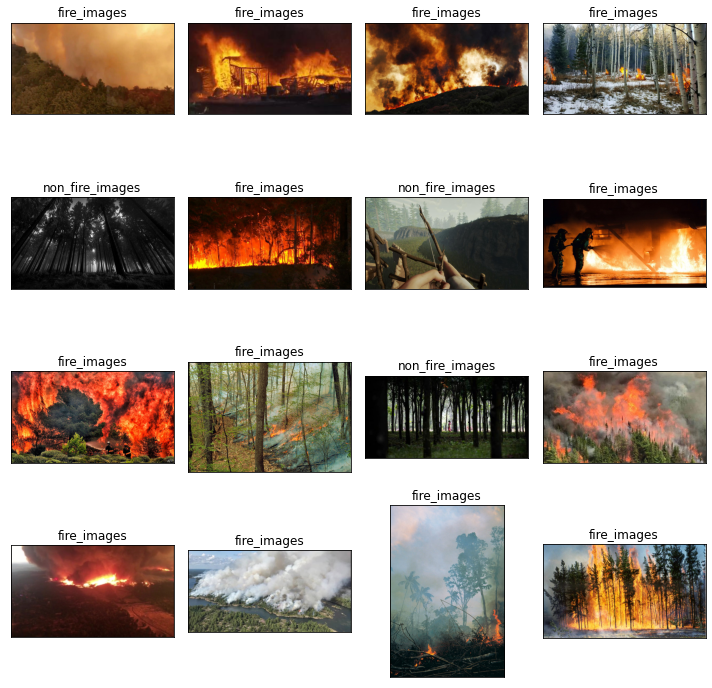

In [8]:
import matplotlib.image as mpimg
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(image_df.Filepath[random_index[i]])
    ax.imshow(image)
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [10]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [11]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [12]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 640 validated image filenames belonging to 2 classes.
Found 159 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


In [13]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [14]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [15]:
# Create checkpoint callback
checkpoint_path = "fires_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [16]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [18]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=0,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "fire_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/fire_classification/20240408-115149
Epoch 1/20
20/20 [==============================] - 29s 1s/step - loss: 0.4150 - accuracy: 0.8188 - val_loss: 0.1942 - val_accuracy: 0.9371
Epoch 2/20
20/20 [==============================] - 25s 1s/step - loss: 0.1805 - accuracy: 0.9438 - val_loss: 0.1095 - val_accuracy: 0.9686
Epoch 3/20
20/20 [==============================] - 25s 1s/step - loss: 0.1026 - accuracy: 0.9781 - val_loss: 0.0813 - val_accuracy: 0.9686
Epoch 4/20
20/20 [==============================] - 23s 1s/step - loss: 0.0767 - accuracy: 0.9844 - val_loss: 0.0679 - val_accuracy: 0.9748
Epoch 5/20
20/20 [==============================] - 24s 1s/step - loss: 0.0648 - accuracy: 0.9781 - val_loss: 0.0585 - val_accuracy: 0.9874
Epoch 6/20
20/20 [==============================] - 23s 1s/step - loss: 0.0531 - accuracy: 0.9875 - val_loss: 0.0507 - val_accuracy: 0.9874
Epoch 7/20
20/20 [==============================] - 24s 1s/step - loss: 0.043

In [21]:
model.save('fires.h5')

In [22]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.06708
Test Accuracy: 98.50%


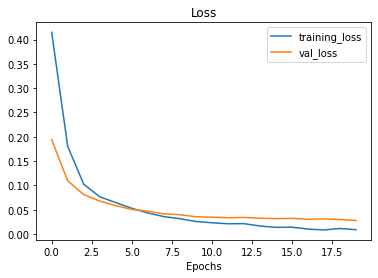

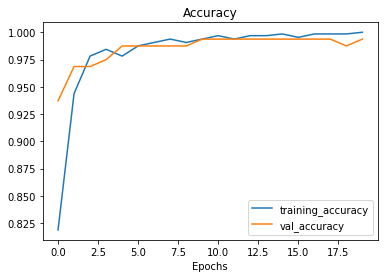

In [23]:
plot_loss_curves(history)

In [24]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['fire_images', 'fire_images', 'non_fire_images', 'fire_images', 'fire_images']


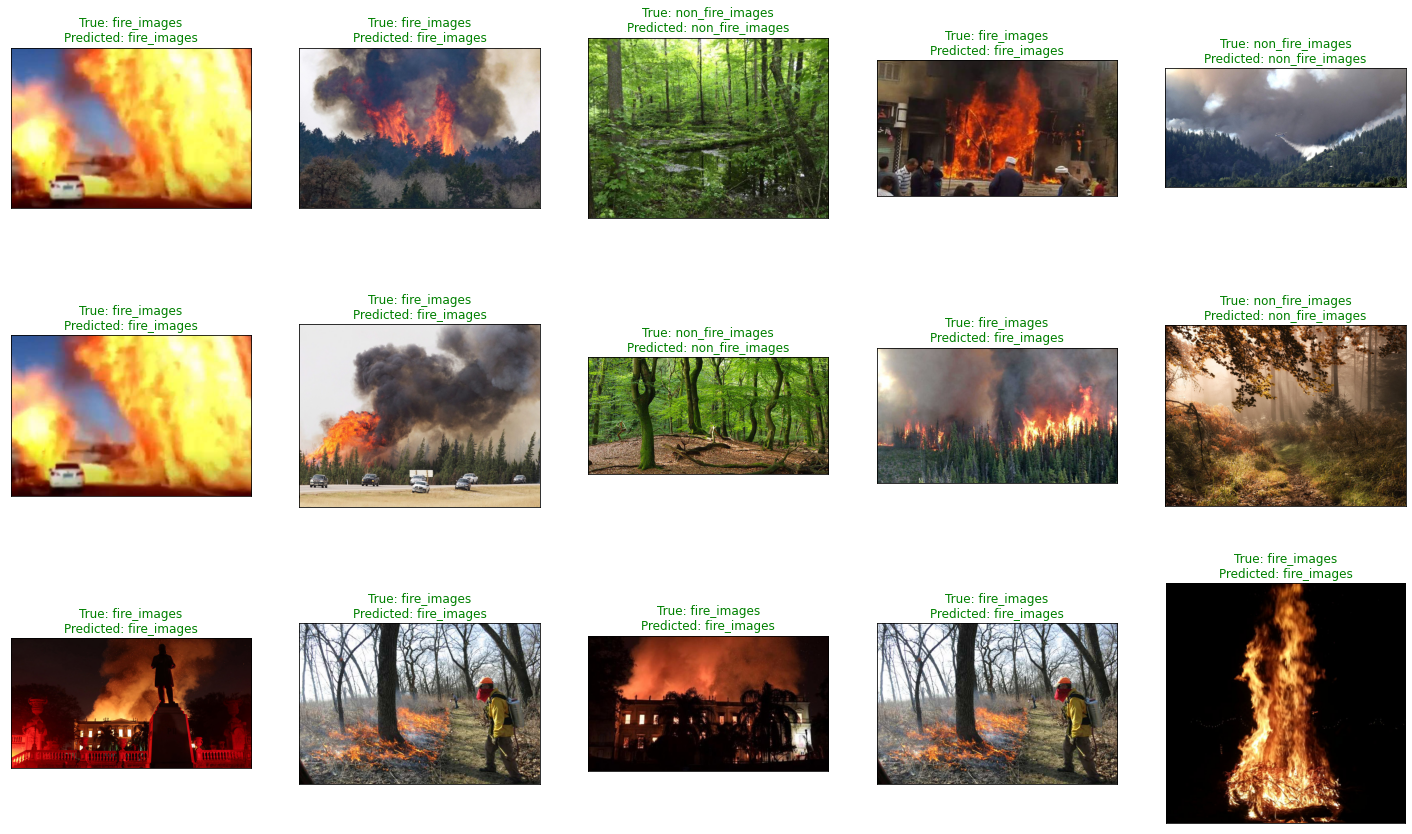

<Figure size 432x288 with 0 Axes>

In [25]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(test_df.Filepath.iloc[random_index[i]])
    ax.imshow(image)
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [26]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                 precision    recall  f1-score   support

    fire_images       0.99      0.99      0.99       158
non_fire_images       0.98      0.95      0.96        42

       accuracy                           0.98       200
      macro avg       0.98      0.97      0.98       200
   weighted avg       0.98      0.98      0.98       200



In [27]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
fire_images,0.987421,0.993671,0.990536,158.000
non_fire_images,0.975610,0.952381,0.963855,42.000
accuracy,0.985000,0.985000,0.985000,0.985
macro avg,0.981516,0.973026,0.977196,200.000
weighted avg,0.984941,0.985000,0.984933,200.000


In [28]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False): 
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """  
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
  
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")


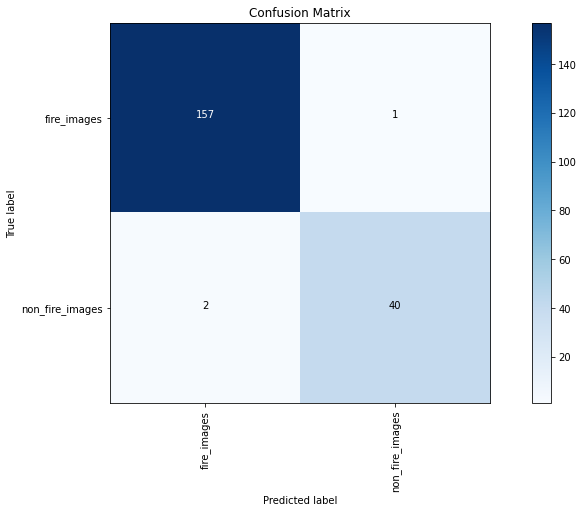

In [29]:
make_confusion_matrix(y_test, pred, list(labels.values()))

Predicted Class: 1, Confidence: 0.79


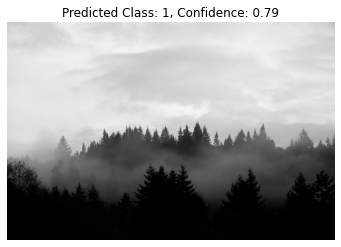

In [31]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model
model = tf.keras.models.load_model('fires.h5')

# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224))  # Resize to match model input size
    img = np.array(img) / 255.0  # Normalize pixel values
    return img

# Function to make predictions on the loaded image
def predict_image(image_path):
    # Load and preprocess the image
    img = load_and_preprocess_image(image_path)
    # Make prediction
    prediction = model.predict(np.expand_dims(img, axis=0))
    # Get the predicted class label
    predicted_class = np.argmax(prediction, axis=1)[0]
    # Get the predicted class probability
    confidence = prediction[0][predicted_class]
    return predicted_class, confidence

# Function to display the selected image and prediction result
def display_image_with_prediction(image_path, predicted_class, confidence):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')  # Hide axis
    plt.title(f"Predicted Class: {predicted_class}, Confidence: {confidence:.2f}")
    plt.show()

# Main function
def main():
    image_path ="/kaggle/input/fire-dataset/fire_dataset/non_fire_images/non_fire.1.png"
    try:
        predicted_class, confidence = predict_image(image_path)
        print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.2f}")
        display_image_with_prediction(image_path, predicted_class, confidence)
    except Exception as e:
        print("Error:", e)

if __name__ == "__main__":
    main()
